In [9]:
import cv2
import numpy as np
import scipy
from skimage import io
import skimage
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import cv2
import numpy as np
import os
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import exposure
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install kaggle

dataset_url = "https://www.kaggle.com/datasets/rmshashi/fabric-defect-dataset"
dataset_name = "rmshashi/fabric-defect-dataset"

path = "/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset"

!mkdir -p "{path}"
!kaggle datasets download -d {dataset_name} -p "{path}"
!unzip -q "{path}/fabric-defect-dataset.zip" -d "{path}"
!rm "{path}/fabric-defect-dataset.zip"

Dataset URL: https://www.kaggle.com/datasets/rmshashi/fabric-defect-dataset
License(s): unknown
 95% 203M/213M [00:02<00:00, 87.6MB/s]
100% 213M/213M [00:02<00:00, 86.4MB/s]


In [5]:
# prompt: get a list fo all the folder and subfoders in teh datset

import os

def get_folders(path):
  """Gets a list of all folders and subfolders within a given path.

  Args:
    path: The path to the directory.

  Returns:
    A list of folder paths.
  """
  folders = []
  for root, _, _ in os.walk(path):
    folders.append(root)
  return folders

folder_list = get_folders(path)

# Print the list of folders
for folder in folder_list:
  folder

In [7]:
folder_list

['/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset',
 '/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset/Data Set',
 '/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset/Data Set/captured',
 '/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset/Data Set/captured/Hole',
 '/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset/Data Set/captured/Lines',
 '/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset/Data Set/hole',
 '/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset/Data Set/horizontal',
 '/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset/Data Set/verticle']

In [8]:
folder

'/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset/Data Set/verticle'

In [10]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/MV/Lab 12/fabric-defect-dataset/Data Set/'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

hole_images = load_images_from_folder(dataset_path + 'captured/Hole')
line_images = load_images_from_folder(dataset_path + 'captured/Lines')

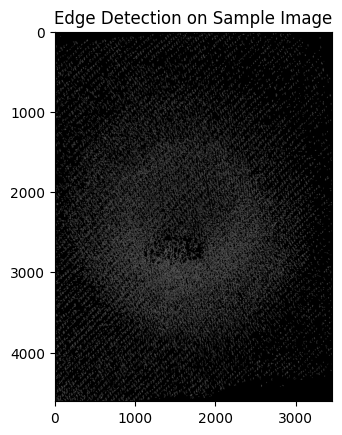

In [11]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges

# Visualize an example of preprocessing
sample_image = hole_images[0]
edges = preprocess_image(sample_image)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection on Sample Image")
plt.show()

# Function to detect line-based defects using Hough Line Transform

In [12]:
def detect_lines(image):
    lines = cv2.HoughLinesP(image, 1, np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
    line_img = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), 255, 2)
    return line_img


# Example of line detection

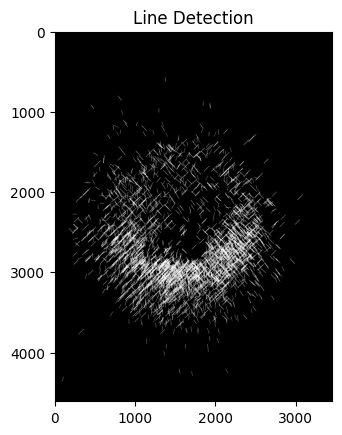

In [14]:
line_detected = detect_lines(edges)
plt.imshow(line_detected, cmap='gray')
plt.title("Line Detection")
plt.show()

# Function to detect circular defects using Hough Circle Transform


In [13]:
def detect_circles(image):
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, minDist=20, param1=50, param2=30, minRadius=5, maxRadius=50)
    circle_img = np.zeros_like(image)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(circle_img, (i[0], i[1]), i[2], 255, 2)
    return circle_img

# Example of circle detection

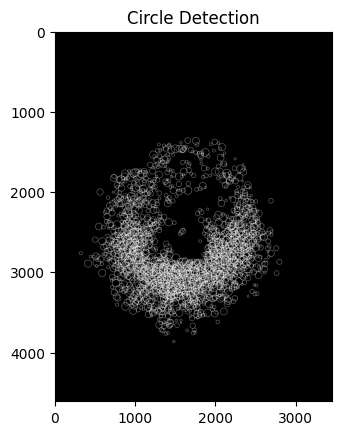

In [15]:
circle_detected = detect_circles(edges)
plt.imshow(circle_detected, cmap='gray')
plt.title("Circle Detection")
plt.show()

# Feature extraction using Histogram of Oriented Gradients (HOG) for texture classification


In [21]:
def extract_hog_features(image):
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

# Function to classify defects based on extracted HOG features


In [23]:
def classify_defect(hog_features, kmeans):
    cluster = kmeans.predict(hog_features.reshape(1, -1))
    if cluster == 0:
        return "Hole"
    elif cluster == 1:
        return "Line"
    else:
        return "Unknown"

# Prepare dataset for training KMeans


In [27]:
# !pip install numpy

import numpy as np

def prepare_kmeans_data(images):
    """
    Prepares data for KMeans clustering by extracting HOG features from images.
    Pads the feature vectors to ensure they have the same dimensions.

    Args:
        images: A list of images.

    Returns:
        A NumPy array of HOG features.
    """
    hog_features = []
    for image in images:
        edges = preprocess_image(image)
        fd, _ = extract_hog_features(edges)
        hog_features.append(fd)

    # Find the maximum length of feature vectors
    max_len = max(len(feature) for feature in hog_features)

    # Pad feature vectors to the maximum length
    padded_features = [np.pad(feature, (0, max_len - len(feature)), 'constant') for feature in hog_features]

    return np.array(padded_features)

# Train KMeans for defect classification


In [28]:
hole_features = prepare_kmeans_data(hole_images)
line_features = prepare_kmeans_data(line_images)
data = np.vstack((hole_features, line_features))
kmeans = KMeans(n_clusters=2, random_state=0).fit(data)

# Function to detect defects, classify them, and generate a caption


In [29]:
def detect_and_classify_defects(image, kmeans):
    edges = preprocess_image(image)
    defect_regions = []
    caption = []

    line_img = detect_lines(edges)
    circle_img = detect_circles(edges)

    if np.sum(line_img) > 0:
        defect_regions.append(line_img)
        defect_type = classify_defect(extract_hog_features(line_img)[0], kmeans)
        caption.append(f"{defect_type} detected (line-based defect).")

    if np.sum(circle_img) > 0:
        defect_regions.append(circle_img)
        defect_type = classify_defect(extract_hog_features(circle_img)[0], kmeans)
        caption.append(f"{defect_type} detected (circular defect).")

    return defect_regions, " ".join(caption)

# Run detection and classification on a sample image


In [30]:
sample_image = hole_images[0]
defect_regions, caption = detect_and_classify_defects(sample_image, kmeans)

# Visualize detected defects


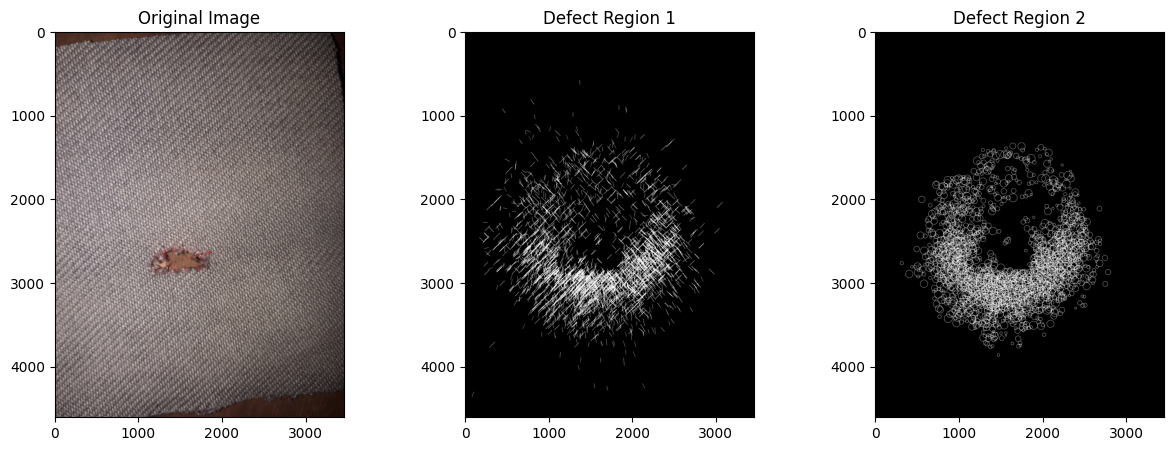

Caption: Hole detected (line-based defect). Hole detected (circular defect).


In [31]:
fig, axs = plt.subplots(1, len(defect_regions) + 1, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
for i, defect_region in enumerate(defect_regions):
    axs[i + 1].imshow(defect_region, cmap='gray')
    axs[i + 1].set_title(f"Defect Region {i + 1}")
plt.show()

print("Caption:", caption)